### Module을 불러오고 장비확인

In [2]:
!pip install pandas

  Using cached pandas-1.3.5-cp37-cp37m-win_amd64.whl (10.0 MB)
  Using cached pytz-2022.1-py2.py3-none-any.whl (503 kB)


You should consider upgrading via the 'C:\Users\raist\.conda\envs\pytorch\python.exe -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from torch.utils.data import DataLoader, Dataset

import seaborn as sns
import wandb

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
class TensorData(Dataset):
    # 외부에 있는 데이터를 가져오기 위해 외부에서 데이터가 들어올 수 있도록, x_data, y_data 변수를 지정
    def __init__(self, x_data, y_data):
        #들어온 x는 tensor형태로 변환
        self.x_data = torch.FloatTensor(x_data)
        # tensor data의 형태는 (배치사이즈, 채널사이즈, 이미지 너비, 높이)의 형태임
        # 따라서 들어온 데이터의 형식을 permute함수를 활용하여 바꾸어주어야함.
        # 아래는 이미지용
        #self.x_data = self.x_data.permute(0,3,1,2)  # 인덱스 번호로 바꾸어주는 것 # 이미지 개수, 채널 수, 이미지 너비, 높이
        self.y_data = torch.FloatTensor(y_data) # float tensor / long tensor 로 숫자 속성을 정해줄 수 있음
        self.len = self.y_data.shape[0]

    # x,y를 튜플형태로 바깥으로 내보내기
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [ ]:

class NormalTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.Normalize(self,mean,std),
        ])

    def __call__(self, img):
        return self.data_transform(img)

### 딥러닝 모델 설계 장비 확인

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

### 데이터 전처리

In [ ]:
df1  = pd.read_csv(".\colonoscopy\history\exp_20220413_131808.csv")

In [ ]:
df2  = pd.read_csv(".\colonoscopy\history\exp_20220413-134511.csv")

In [ ]:
df3  = pd.read_csv(".\colonoscopy\history\exp_20220413-141532.csv")

In [ ]:
test_df  = pd.read_csv(".\colonoscopy\history\exp_20220413-155652.csv")

In [ ]:
df1

In [ ]:
index = [".joy_x", ".joy_y"]

In [ ]:
df1.index

In [ ]:
df1 = df1[index]

In [ ]:
df1

In [ ]:
df2 = df2[index]

In [ ]:
df3 = df3[index]

In [ ]:
test_df = test_df[index]

In [ ]:
label1 = pd.read_csv(".\colonoscopy\labels\exp_20220413-131808.csv")

In [ ]:
label2 = pd.read_csv(".\colonoscopy\labels\exp_20220413-134511.csv")

In [ ]:
label3 = pd.read_csv(".\colonoscopy\labels\exp_20220413-141532.csv")

In [ ]:
test_label = pd.read_csv(".\colonoscopy\labels\exp_20220413-154612.csv")

In [ ]:
label_index = ["X","Y"]

In [ ]:
label1 = label1[label_index]

In [ ]:
label1

In [ ]:
label2 = label2[label_index]

In [ ]:
label3 = label3[label_index]

In [ ]:
test_label = test_label[label_index]

In [ ]:
df_x1 = np.array(df1[".joy_x"])
df_x2 = np.array(df2[".joy_x"])
df_x3 = np.array(df3[".joy_x"])
df_xt = np.array(test_df[".joy_x"])

In [ ]:
df_y1 = np.array(df1[".joy_y"])
df_y2 = np.array(df2[".joy_y"])
df_y3 = np.array(df3[".joy_y"])
df_yt = np.array(test_df[".joy_y"])

In [ ]:
label_x1 = np.array(label1["X"])
label_x2 = np.array(label2["X"])
label_x3 = np.array(label3["X"])
label_xt = np.array(test_label["X"])

In [ ]:
label_y1 = np.array(label1["Y"])
label_y2 = np.array(label2["Y"])
label_y3 = np.array(label3["Y"])
label_yt = np.array(test_label["Y"])

### input : pixel -----> output : joystick

#### normal

In [ ]:
def n_in(x):
    temp = (x+1)/2
    return temp
def n_out_x(y):
    temp = y/640
    return temp
def n_out_y(y):
    temp = y/480
    return temp

In [ ]:
df_x_n1,df_x_n2,df_x_n3,df_xt_n = n_in(df_x1),n_in(df_x2),n_in(df_x3),n_in(df_xt)
df_y_n1,df_y_n2,df_y_n3,df_yt_n = n_in(df_y1),n_in(df_y2),n_in(df_y3),n_in(df_yt)

label_x_n1,label_x_n2,label_x_n3,label_xt_n, = n_out_x(label_x1),n_out_x(label_x2),n_out_x(label_x3),n_out_x(label_xt)
label_y_n1,label_y_n2,label_y_n3,label_yt_n, = n_out_y(label_y1),n_out_y(label_y2),n_out_y(label_y3),n_out_y(label_yt)
#df_y_n = (df_y - np.min(df_y))/np.ptp(df_y);
#label_x_n = (label_x - np.min(label_x))/np.ptp(label_x);
#label_y_n = (label_y - np.min(label_y))/np.ptp(label_y);
plt.plot(label_y_n1)

#### squence

In [ ]:
s = 9

In [ ]:
len(df_x1)-s+1,len(df_x2)-s+1,len(df_x3)-s+1

In [ ]:
temp_x = torch.zeros(len(df_x1)-s+1+len(df_x2)-s+1,s,2)
temp_y = torch.zeros(len(df_x1)-s+1+len(df_x2)-s+1,1,2)

temp_xt = torch.zeros(len(df_x3)-s+1,s,2)
temp_yt = torch.zeros(len(df_x3)-s+1,1,2)

# train
#x
for i in range(0,len(df_x1)-s+1):
    temp_x[i]=np.transpose(torch.tensor([label_x_n1[i:i+s],label_y_n1[i:i+s]]))
for i in range(0,len(df_x2)-s+1):
    temp_x[i+len(df_x1)-s+1]=np.transpose(torch.tensor([label_x_n2[i:i+s],label_y_n2[i:i+s]]))
#for i in range(0,len(df_x3)-15+1):
#    temp_x[i+len(df_x1)-15+1+len(df_x2)-15+1]=np.transpose(torch.tensor([label_x_n3[i:i+15],label_y_n3[i:i+15]]))
    
#y

for i in range(0,len(df_x1)-s+1):
    temp_y[i] = torch.tensor([df_x_n1[i+s-1].item(),df_y_n1[i+s-1].item()])
for i in range(0,len(df_x2)-s+1):
    temp_y[i+len(df_x1)-s+1] = torch.tensor([df_x_n2[i+s-1].item(),df_y_n2[i+s-1].item()])
#for i in range(0,len(df_x3)-15+1):
#    temp_y[i+len(df_x1)-15+1+len(df_x2)-15+1] = torch.tensor([df_x_n3[i+14:i+15].item(),df_y_n3[i+14:i+15].item()])

# test
for i in range(0,len(df_x3)-s+1):
    temp_xt[i]=np.transpose(torch.tensor([label_x_n3[i:i+s],label_y_n3[i:i+s]]))
    
for i in range(0,len(df_x3)-s+1):
    temp_yt[i] = torch.tensor([df_x_n3[i+s-1].item(),df_y_n3[i+s-1].item()])
    
    

In [ ]:
temp_xt.size()

### dataset 생성

In [ ]:
train_data = TensorData(temp_x, temp_y)

In [ ]:
BATCH_SIZE = 100

train = TensorData(temp_x, temp_y)
val = TensorData(temp_xt[:int(len(temp_xt)*0.5)],temp_yt[:int(len(temp_xt)*0.5)])
test = TensorData(temp_xt[int(len(temp_xt)*0.5):],temp_yt[int(len(temp_xt)*0.5):])

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
val.y_data.size()

In [ ]:
#train_data_x = TensorData(df_x_n, label_x_n)

In [ ]:
#train_data_y = TensorData(df_y_n, label_y_n)

### 모델 생성

In [ ]:
s

In [ ]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self,kernel = 5,in_channel=2, out_channel=2,out_channels=32,middle=1024,final = 1024):
        super(Model, self).__init__()
        self.conv1d_1 = nn.Conv1d(in_channels=in_channel,
                                   out_channels=out_channels,
                                   kernel_size = kernel,
                                   stride = 1)

        self.fc1 = nn.Linear((9-kernel+1)*out_channels,middle) # s-kernel
        self.fc2 = nn.Linear(middle,final)
        self.fc3 = nn.Linear(final,16)
        self.fc4 = nn.Linear(16,2)
            
        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d((9-kernel+1)*out_channels)
        self.bn2 = nn.BatchNorm1d(middle)
        self.bn3 = nn.BatchNorm1d(final)
        self.bn4 = nn.BatchNorm1d(16)
        self.sigmoid = nn.Sigmoid()
            
        self.dropout = nn.Dropout(0.25)
        self.flat = nn.Flatten()
        
    def forward(self,x): 
        # Raw x shape : (B, S, F)
        # Shape : (B, F, S)
        #print(x.size())
        x = x.transpose(1,2)
        
        # Shape : (B, F, S) == (B, C, S)
        x = self.conv1d_1(x)
        # Shape : (B, C, S) 
        #print(x.size())
        x = self.flat(x)
        #x = x.transpose(1,2)
        x = self.bn1(x)
        x = self.fc1(x)
        #print(x.size())
        #x = self.relu(x)

        x = self.leaky(x)
        x = self.bn2(x)        
#        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.leaky(x)
#        x = self.dropout(x)
        x = self.bn3(x)
        x = self.fc3(x)
        x = self.leaky(x)
        x = self.bn4(x)
        x = self.fc4(x)

        #print(x.size())
                     
                    
                     
        
        return x



### 가중치 초기화

#### 초기화를 위한 함수 만들기

In [ ]:
def init_constants(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight.data,0)
        nn.init.constant_(m.bias.data, 0)
        
def init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 1.0)
        nn.init.normal_(m.bias, 0, 1.0)

def init_xaiver(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight, 1.0)

        
def init_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, 0, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm1d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

### 학습하기


In [ ]:
def training_epoch(train_loader, network, loss_func, optimizer,scheduler, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 300
    
    
    for batch_idx, (xb, label) in enumerate(train_loader):       
        
        xb, label = xb.to(device), label.to(device)
        #print(xb)
        batch_size = xb.size()[0]
        #xb = xb.view(batch_size,-1)
        label = label.view(batch_size,-1)
        #print(label.size())
        # 미분값의 초기화
        optimizer.zero_grad()
        #xb = xb.view(xb.shape[0],1)
        #Forward propagation 계산
        outputs = network(xb)
        
        # MSE 함수로 로스 구하기

        loss = loss_func(outputs,label)
        train_losses.append(loss.item())

        # Gradinet 구하기
        loss.backward()

        # weight값 update 하기
        optimizer.step()
        #scheduler.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.2f}%)]\tLoss: {:.6f}'
                  .format(epoch+1, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            print("lr: ", optimizer.param_groups[0]['lr'])
            
    return train_losses

In [ ]:
def test_epoch(test_loader, network, loss_func, val = False):
    correct = 0
    
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (xb, label) in enumerate(test_loader):
            xb, label = xb.to(device), label.to(device)
            batch_size = xb.size()[0]
            #print(xb.size())
            #xb = xb.view(batch_size,-1)
            #print(label.size())
            label = label.view(batch_size,-1)
            #print(label.size())
            #image = image.view([-1 , 1, 5])
            # Forward propagration 계산하기.
            outputs= network(xb)

            # MSE 함수를 적용하여 loss를 구하기
            loss = loss_func(outputs, label)
            test_losses.append(loss.item())
            avg_loss = np.mean(test_losses)


        #중간결과 출력
        if val is True:
            print('Validation set: Loss: {:.5f}\n'.format(avg_loss))
        
        else:
            print('Test set: Loss: {:.5f}\n'.format(avg_loss))
        
    return test_losses


### 정의된 함수로 학습 함수 만들기

In [ ]:
def training(network, learning_rate = 0.001, epoches = 100):
    
    

    
    cls_loss = torch.nn.MSELoss().to(device)
    optimizer =torch.optim.Adam(network.parameters(),learning_rate)
#    scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                        lr_lambda=lambda epoch: 0.95 ** epoch)

#    optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    train_losses_per_epoch = []
    val_losses_per_epoch = []
    test_losses_per_epoch = []
  


    wandb.init(project='colonscope', entity='sharpit')
    wandb.watch(network,cls_loss,log='all')
    
    
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses = training_epoch(train_loader,network,cls_loss,optimizer,scheduler, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Loss {:.6f}'.format(average_loss))

        wandb.log({'Epoch':epoch, 'loss':np.mean(train_losses)})
        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        
        with torch.no_grad():
            val_losses = test_epoch(val_loader, network, cls_loss, True)

        val_losses_per_epoch.append(np.mean(val_losses))
#        scheduler.step(np.mean(val_losses))
    with torch.no_grad():
        test_losses = test_epoch(test_loader, network, cls_loss, False)
        
    
        
    return train_losses_per_epoch,val_losses_per_epoch


### x 훈련

In [ ]:
model1 = Model(kernel=7,out_channels=16,middle =32,final=16)
model1 = model1.cuda()
model1 = model1.apply(initialize_weights)     # relu
#model1 = model1.apply(init_xaiver)      # sigmoid
loss = nn.MSELoss()


In [2]:

train_loss, val_loss  = training(model1,0.001,1000)

NameError: name 'training' is not defined

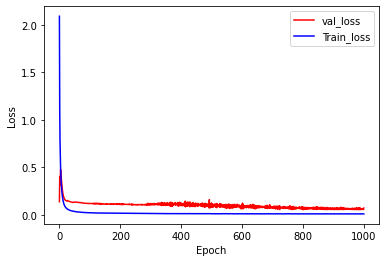

In [530]:
#plt.plot(test_loss,'r',label = 'Test_loss')
plt.plot(val_loss,'r',label = 'val_loss')
plt.plot(train_loss,'b',label = 'Train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

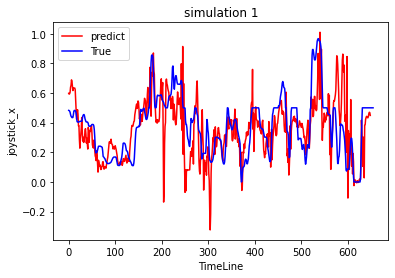

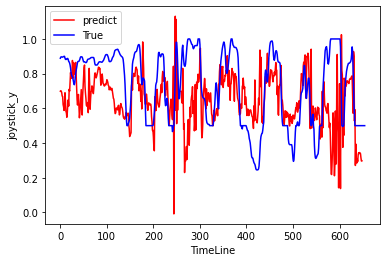

In [531]:
#simul1
plt.figure(1)
plt.title('simulation 1')
plt.plot(model1(train.x_data[:len(df_x1)-15+1].to(device))[:,0].detach().cpu(),'r', label='predict')
plt.plot(df_x_n1[s-1:],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_x')
plt.legend()
plt.figure(2)
plt.plot(model1(train.x_data[:len(df_x1)-15+1].to(device))[:,1].detach().cpu(),'r', label='predict')
plt.plot(df_y_n1[s-1:],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_y')
plt.legend()

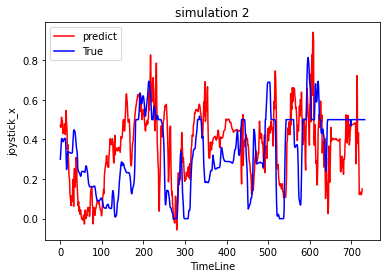

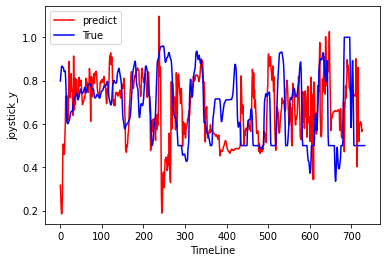

In [532]:
#simul2
plt.figure(1)
plt.title('simulation 2')
plt.plot(model1(train.x_data[len(df_x1)-15+1:len(df_x1)-15+1+len(df_x2)-15+1].to(device))[:,0].detach().cpu(),'r', label='predict')
plt.plot(df_x_n2[s-1:],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_x')
plt.legend()
plt.figure(2)
plt.plot(model1(train.x_data[len(df_x1)-15+1:len(df_x2)-15+1+len(df_x1)-15+1].to(device))[:,1].detach().cpu(),'r', label='predict')
plt.plot(df_y_n2[s-1:],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_y')
plt.legend()

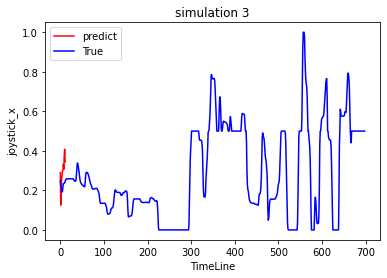

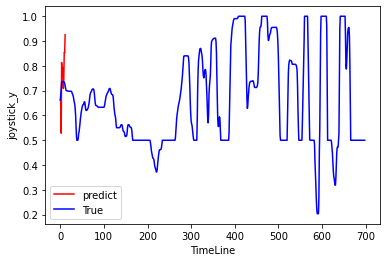

In [351]:
#simul3
plt.figure(1)
plt.title('simulation 3')
plt.plot(model1(train.x_data[len(df_x1)-15+1+len(df_x2)-15+1:].to(device))[:,0].detach().cpu(),'r', label='predict')
plt.plot(df_x_n3[14:],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_x')
plt.legend()
plt.figure(2)
plt.plot(model1(train.x_data[len(df_x1)-15+1+len(df_x2)-15+1:].to(device))[:,1].detach().cpu(),'r', label='predict')
plt.plot(df_y_n3[14:],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_y')
plt.legend()

In [352]:
len(model1(temp_x.to(device))[:,1].detach().cpu())

1388

In [353]:
len(df_y_n[14:])

NameError: name 'df_y_n' is not defined

In [739]:
test.y_data.size()

torch.Size([98, 1, 2])

### 전체 경향성

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


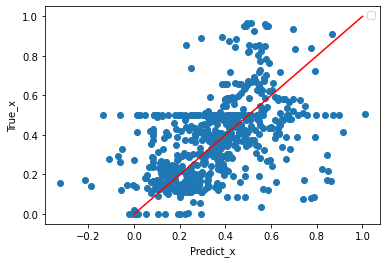

In [533]:
plt.scatter(model1(temp_x[:len(df_x1)-15+1].to(device))[:,0].detach().cpu(),df_x_n1[14:664])
plt.plot([0,1],[0,1],'red')
plt.xlabel('Predict_x')
plt.ylabel('True_x')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


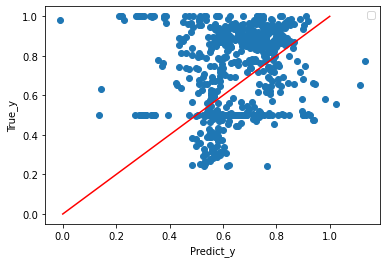

In [534]:
plt.scatter(model1(temp_x[:len(df_x1)-15+1].to(device))[:,1].detach().cpu(),df_y_n1[14:664])
plt.plot([0,1],[0,1],'red')
plt.xlabel('Predict_y')
plt.ylabel('True_y')
plt.legend()

### validation 경향성

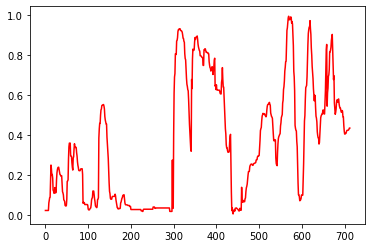

In [113]:
plt.plot(label_x_n3,'r', label='predict')

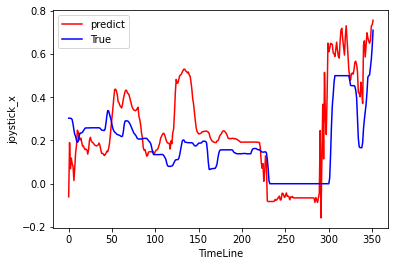

In [330]:
plt.plot(model1(val.x_data.to(device))[:,0].detach().cpu(),'r', label='predict')
plt.plot(val.y_data[:,:,0],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_x')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


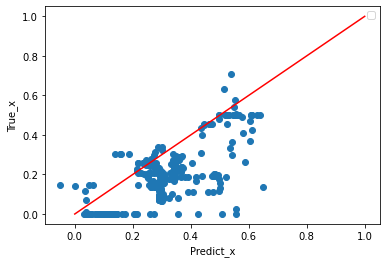

In [357]:
plt.scatter(model1(val.x_data.to(device))[:,0].detach().cpu(),val.y_data[:,:,0])
plt.plot([0,1],[0,1],'red')
plt.xlabel('Predict_x')
plt.ylabel('True_x')
plt.legend()

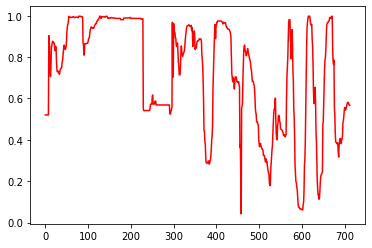

In [239]:
plt.plot(label_y_n3,'r', label='predict')

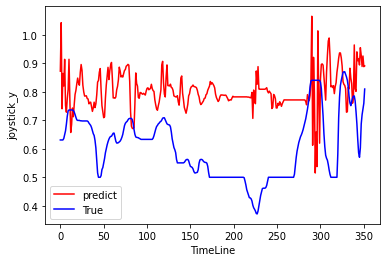

In [332]:
plt.plot(model1(val.x_data.to(device))[:,1].detach().cpu(),'r', label='predict')
plt.plot(val.y_data[:,:,1],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_y')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


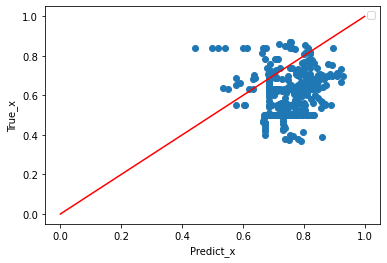

In [486]:
plt.scatter(model1(val.x_data.to(device))[:,1].detach().cpu(),val.y_data[:,:,1])
plt.plot([0,1],[0,1],'red')
plt.xlabel('Predict_x')
plt.ylabel('True_x')
plt.legend()

### testset 경향성

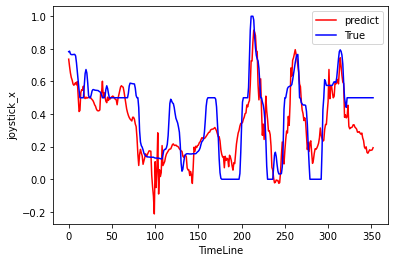

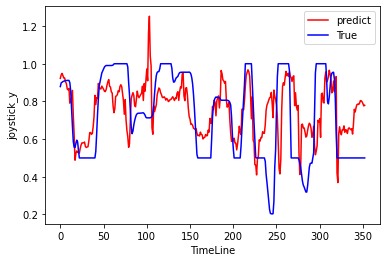

In [334]:
plt.figure(1)
plt.plot(model1(test.x_data.to(device))[:,0].detach().cpu(),'r', label='predict')
plt.plot(test.y_data[:,:,0],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_x')
plt.legend()
plt.figure(2)
plt.plot(model1(test.x_data.to(device))[:,1].detach().cpu(),'r', label='predict')
plt.plot(test.y_data[:,:,1],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_y')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


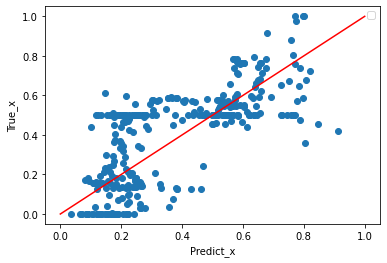

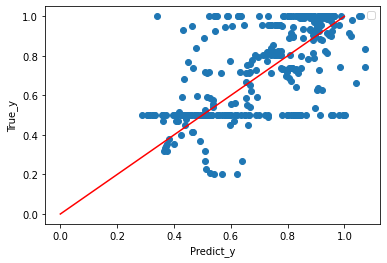

In [475]:
plt.figure(1)
plt.scatter(model1(test.x_data.to(device))[:,0].detach().cpu(),test.y_data[:,:,0])
plt.plot([0,1],[0,1],'red')
plt.xlabel('Predict_x')
plt.ylabel('True_x')
plt.legend()

plt.figure(2)
plt.scatter(model1(test.x_data.to(device))[:,1].detach().cpu(),test.y_data[:,:,1])
plt.plot([0,1],[0,1],'red')
plt.xlabel('Predict_y')
plt.ylabel('True_y')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


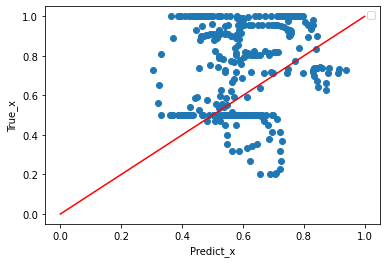

In [271]:
plt.scatter(model1(test.x_data.to(device))[:,1].detach().cpu(),test.y_data[:,:,1])
plt.plot([0,1],[0,1],'red')
plt.xlabel('Predict_x')
plt.ylabel('True_x')
plt.legend()

###  모델저장

In [686]:
PATH = 'C:\song\colonoscopy\weight/'

In [687]:
torch.save(model1, PATH + 'model_CNN_reverse_1lay.pt')
torch.save(model1.state_dict(), PATH + 'model_CNN_reverse_state_dict_1lay.pt')


### model 불러오기

In [356]:
model1.load_state_dict(torch.load(PATH + 'model_CNN_reverse_state_dict.pt'))
model1.to(device)

RuntimeError: Error(s) in loading state_dict for Model:
	size mismatch for fc2.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([216, 512]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([216]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([2, 256]) from checkpoint, the shape in current model is torch.Size([2, 216]).

In [358]:
model1 = torch.load( PATH + 'model_CNN_reverse.pt')

### model weight visualization

In [122]:
grad_output.data

NameError: name 'grad_output' is not defined